In [13]:

!pip3 install lxml
!pip3 install numpy
!pip3 install pandas
!pip3 install lxml
!pip3 install Markdown2
!pip3 install tinycss
!pip3 install dukpy
!pip3 install stop-words
!pip3 install matplotlib
!pip3 install networkx

.............Processing Page index:0  0/100.............
.............Processing Page index:1  1/100.............
.............Processing Page index:2  2/100.............
.............Processing Page index:3  3/100.............
.............Processing Page index:4  4/100.............
.............Processing Page index:5  5/100.............
.............Processing Page index:6  6/100.............
.............Processing Page index:7  7/100.............
.............Processing Page index:8  8/100.............
.............Processing Page index:9  9/100.............
.............Processing Page index:10  10/100.............
.............Processing Page index:11  11/100.............
.............Processing Page index:12  12/100.............
.............Processing Page index:13  13/100.............
.............Processing Page index:14  14/100.............
.............Processing Page index:15  15/100.............
.............Processing Page index:16  16/100.............
.............Proc

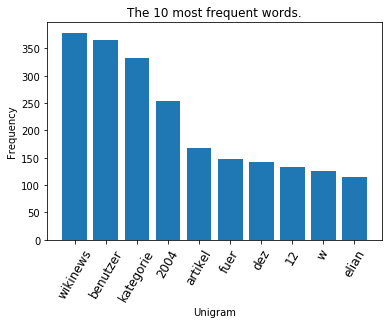

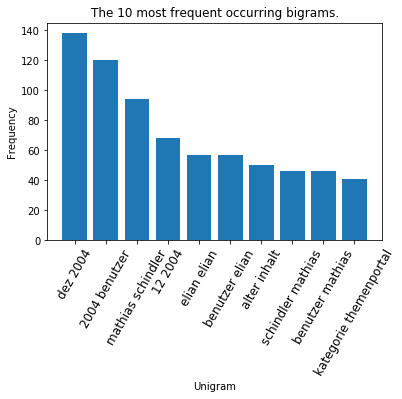

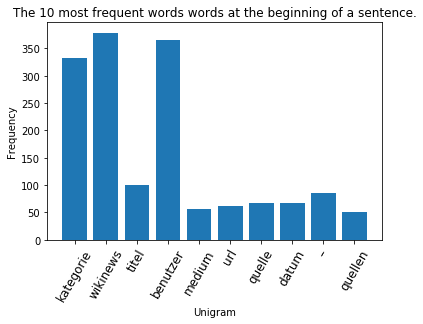

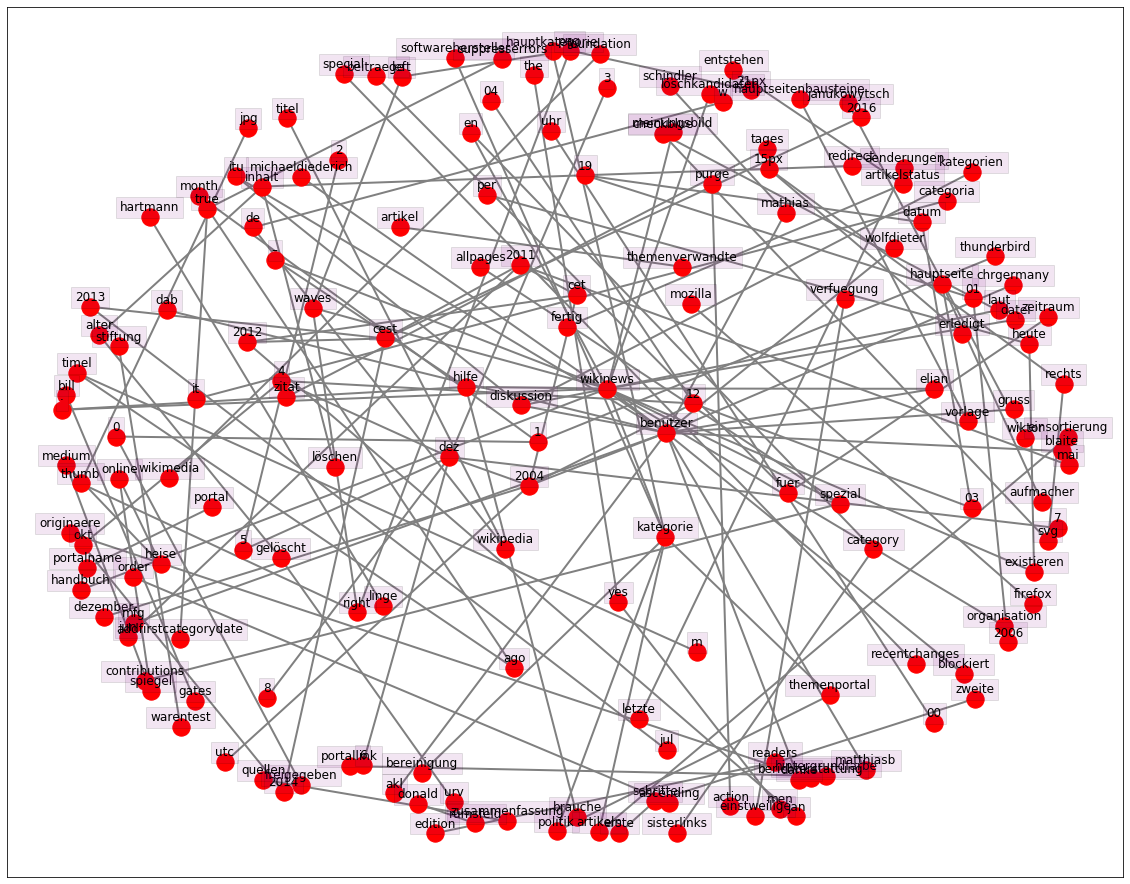

In [35]:
from lxml import etree
from bs4 import BeautifulSoup
from markdown import markdown
from stop_words import get_stop_words
import pandas as pd
import re
import tinycss
import dukpy
import string
import os
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import random

fileName = "dewikinews-20190720-pages-articles-multistream.xml"
namespace = 'http://www.mediawiki.org/xml/export-0.10/'

#To reduce the texts to process, it can set a random number to define how many pages
#0 means to process all pages; non-zero means to limit the pages
random_pages = 100

class Cralwer:
    xml_path = ''
    tree = None
    title = ''           
    unigram_df = pd.DataFrame(columns=['unigram','count', 'beginning_count'])
    bigram_df = pd.DataFrame(columns=['bigram','count'])
    
    def __init__(self, xml_path):
        if xml_path:
            self.xml_path = xml_path
            self.tree = self.loadXML(xml_path)
            
    def loadXML(self, url):     
        try:            
            tree = etree.parse(url)
            return tree
        except Exception as e:            
            print("An exception occurred in loadXML") 
            print( str(e))

    def xpath(self, tree, path):
            try:            
                nodes = tree.xpath(path)
                return nodes
            except Exception as e:            
                print("An exception occurred in xpath", str(e))


    def findURL(self, text):  
        if not text:
            return ""
        urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text)
        urls = urls + re.findall('irc://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text)
        return urls 
    
    def validateCSS(self, text):
        '''
        # Detect if all texts are CSS  
        '''
        try:
            stylesheet = tinycss.make_parser().parse_stylesheet(text)
            if  len(stylesheet.rules) > 0 and len(stylesheet.errors) == 0:
                return True
        except Exception as e:
            #print('Invalid css. ')
            pass
        return False
    
    def validateJavascript(self, text):
        '''
        # Detect if all texts are Javascript
        '''
        try:
            jsx = dukpy.jsx_compile(text);
        except Exception as e:
            #print('Invalid Javascript.')
            pass
        return False
    
    def markdown2HTML(self, text):
        try:
            text = re.sub('\*{2}\#+([^*]+)\*{2}', '** \\1 **', text)
            return markdown(text, extensions=[
                'markdown.extensions.sane_lists',
                'markdown.extensions.nl2br'])
        except Exception as e:
            return ""
        return text
    
    def removeUmlauts(self, text):
        if not text:
            return ""
        return text.replace("ö ", "oe").replace("ü", "ue").replace("ä", "ae")\
        .replace("Ö", "Oe").replace("Ü ", "Ue").replace("Ä", "Ae").replace("ß", "ss")
    

    def removePunctuation(self, text):
        if not text:
            return ""
        translator = re.compile('[%s]' % re.escape(string.punctuation))
        return translator.sub(' ', text.replace("“", '')\
                              .replace("„", "").replace("-", "").replace("‘", "").replace("‚", ""))
    
    def cleanText(self, text):
        '''
        # Function to clean text by handling CSS file, Javascript file,
        # HTML tags, HTML attributes, punctuation, German stopwords, Umlauts
        # return list of sentences
        '''
        if not text:
            return ""
        
        # Reserve HTML Entities and check to avoid completely CSS and Javascript scripts
        text = text.replace("&lt;", "<").replace("&gt;", ">").replace("&nbsp;", "")
        if self.validateCSS(text):
            return ""
        elif self.validateJavascript(text):
            return ""
        
        #Convert from markdown to HTML text
        text = self.markdown2HTML(text)
        
        # create a new bs4 object from the HTML data loaded
        soup = BeautifulSoup(text, features="lxml") 
        
        # Remove all unwanted tags 
        for script in soup(["script", "style", "imagemap", "DynamicPageList"]): 
            script.extract()
        text = soup.get_text()
        
        # Remove remaining inline tags' attributes   
        aligns = re.findall(r'align="(.*?)"', text)
        for a in aligns:
            text = text.replace( 'align="' + a + '"', '')        
        styles = re.findall(r'style="(.*?)"', text)
        for a in styles:
            text = text.replace( 'style="' + a + '"', '')
        cellpaddings = re.findall(r'cellpadding="(.*?)"', text)
        for a in cellpaddings:
            text = text.replace( 'cellpadding="' + a + '"', '')
        colspans = re.findall(r'colspan="(.*?)"', text)
        for a in colspans:
            text = text.replace( 'colspan="' + a + '"', '')
            
        #Remove URLs
        for url in self.findURL(text):
            text = text.replace(url, '')
        
        #Remove Umlauts
        text = self.removeUmlauts(text)
                        
        #Remove punctuation
        text = self.removePunctuation(text)
        return text
    
    
    def generate_ngrams(self, tokens, n):
        '''
        Reference: http://www.albertauyeung.com/post/generating-ngrams-python/
        '''        
        # Use the zip function to help us generate n-grams
        # Concatentate the tokens into ngrams and return
        ngrams = zip(*[tokens[i:] for i in range(n)])
        return [" ".join(ngram) for ngram in ngrams]
    
            
    def crawlData(self):
        """funtion to crawl text entities from the xml     
        """
        german_stopwords = get_stop_words("german")
        if self.tree:
            #Get all text entities
            texts = self.xpath(self.tree, "//*[local-name() ='text'  and namespace-uri()='" + namespace + "']/text()")
            if len(texts) > 0 :
                #Create index to interate
                index_to_loop = []
                if random_pages > 0:
                    index_to_loop = [random.randint(0, len(texts)) for index in range(random_pages)]
                else:
                    index_to_loop = [index for index in range(len(texts))]
                #Iterate to get texts from each page
                index = 0
                count = 0
                #for index in range(random_pages):
                for index in index_to_loop:
                    text = texts[index]
                    print(".............Processing Page index:" + str(index)\
                          + "  " + str(count) + "/" + str(len(index_to_loop)) + ".............")
                    count = count + 1
                    #Clean the text and lowercase it
                    text = self.cleanText(text).lower()
                    # break into sentencs and remove leading and trailing space on each
                    sentencs = [sentence.strip() for sentence in text.splitlines() if sentence]
                     
                    for sentence in sentencs:
                        # Remove Germany stopwords when tokenizing
                        tokens = [token.lower().strip() for token in sentence.split(" ") if token and token not in german_stopwords]
                        sentence_bigrams = self.generate_ngrams(tokens, 2)
                        beginning_count = [0 for x in range(len(tokens))]
                        if len(beginning_count) > 0 :
                            beginning_count[0] = 1
                        df1 = pd.DataFrame({"unigram": tokens,
                                            "count" : [1 for t in range(len(tokens))],
                                            "beginning_count" :   beginning_count  }) 
                        # Update the count numbers of bigrams in each page
                        df2 = pd.DataFrame({"bigram": sentence_bigrams,
                                            "count" : [1 for t in range(len(sentence_bigrams))] })
                        
                        self.unigram_df = pd.concat([self.unigram_df, df1], ignore_index=True)
                        self.bigram_df = pd.concat([self.bigram_df, df2], ignore_index=True)

        #Sort dataframe
        self.unigram_df = self.unigram_df.groupby(['unigram']).agg({'count': 'sum', 'beginning_count': 'sum'}).sort_values(by =['count',], ascending = False)
        self.bigram_df = self.bigram_df.groupby(['bigram']).agg({'count': 'sum'}).sort_values(by =['count',], ascending = False)
        
        return
    
    def exportDf2CSV(self, path):
        self.unigram_df.to_csv(path + r'/unigram_df.csv')
        self.bigram_df.to_csv(path + r'/bigram_df.csv')
        print(".................CSV saved.................")
        print("................." + path + ".................")
        return
    
    def readCSV2Df(self, path):
        self.unigram_df = pd.read_csv(path + r'/unigram_df.csv')
        self.bigram_df = pd.read_csv(path + r'/bigram_df.csv')
        print(".................CSV read.................")
        return
    
    def plot_bar_x(self, labels, freq, xlabel, ylabel, title):
        index = np.arange(len(labels))
        plt.bar(index, freq)
        plt.xlabel(xlabel, fontsize=10)
        plt.ylabel(ylabel, fontsize=10)
        plt.xticks(index, labels, fontsize=12, rotation=60)
        plt.title(title)
        plt.show()
        return
    
    def visualizeBigramsNetworks(self):
        #    Apple condition to bigrams with more than 5 occurrences
        bigram_lst = self.bigram_df[self.bigram_df["count" ].apply(pd.to_numeric) > 5] .set_index('bigram').T.to_dict('records')
        if len(bigram_lst) == 0:
            return
        
        bigram_dict = bigram_lst[0]
        
        # Create network plot 
        graph = nx.Graph()
        
        # Add edges to combine bigrams with more than 5 occurrences
        for bigram, count in bigram_dict.items():
            words = bigram.split(" ", 2)
            #the higher the weight, the closer the distance of two nodes will be
            graph.add_edge(words[0], words[1], weight=count)
            
        # the width and height of the figure in inches    
        fig, ax = plt.subplots(figsize=(20, 16))
        
        # Position nodes using Fruchterman-Reingold force-directed algorithm. k =Optimal distance between nodes. 
        pos = nx.spring_layout(graph, k=1)
        
        # Plot networks
        nx.draw_networkx(graph, pos,
                         font_size=12,
                         width=2,
                         edge_color='grey',
                         node_color='red',
                         with_labels = False,
                         ax=ax)        
        # Create offset labels of the nodes
        for key, value in pos.items():
            x, y = value[0], value[1]+.015
            ax.text(x, y,
                    s=key,
                    bbox=dict(facecolor='purple', alpha=0.1),
                    horizontalalignment='center', fontsize=12)
            
        plt.show()
        
        return

    
    def displayGraphics(self):
        # Plot the 10 most frequent words (x-axis words, y-axis frequency)
        self.unigram_df = self.unigram_df.sort_values(by =['count',], ascending = False)
        top_10 = self.unigram_df["unigram"].tolist()[:10]
        freq = self.unigram_df["count"].tolist()[:10]
        self.plot_bar_x(top_10, freq, "Unigram", "Frequency", "The 10 most frequent words.")
        
        # Plot the 10 most frequently occurring bigrams (a new count, not the bigrams from the previous step) and plot them
        self.bigram_df = self.bigram_df.sort_values(by =['count',], ascending = False)
        top_10 = self.bigram_df["bigram"].tolist()[:10]
        freq = self.bigram_df["count"].tolist()[:10]
        self.plot_bar_x(top_10, freq, "Unigram", "Frequency", "The 10 most frequent occurring bigrams.")
        
        # Plot the 10 most frequent words _at the beginning of a sentence_
        self.unigram_df = self.unigram_df.sort_values(by =['beginning_count',], ascending = False)
        top_10 = self.unigram_df["unigram"].tolist()[:10]
        freq = self.unigram_df["count"].tolist()[:10]
        self.plot_bar_x(top_10, freq, "Unigram", "Frequency", "The 10 most frequent words words at the beginning of a sentence.")
        
        return
    
def main():
    c = Cralwer(fileName)
    c.crawlData()
    
    
    #Save unigram and bigram to csv for refrence
    curr_path = os.getcwd()
    c.exportDf2CSV(curr_path)
    c.readCSV2Df(curr_path)
    c.displayGraphics()
    c.visualizeBigramsNetworks()
    
if __name__== "__main__":
    main()